## Panorama Stitching in OpenCV

---

Dr.-Ing. Antje Muntzinger, Hochschule für Technik Stuttgart

antje.muntzinger@hft-stuttgart.de

---

In this notebook, we will stitch a panorama from single images in OpenCV. We will explore two methods: a fast method using OpenCV's `Stitcher` class that handles most intermediate steps automatically, and a more hands-on method where we implement the different steps one by one.

In [1]:
# install required packages specified in pipfile
!pipenv install

Installing dependencies from Pipfile.lock (fd2ab2)...
To activate this project's virtualenv, run pipenv shell.
Alternatively, run a command inside the virtualenv with pipenv run.


Courtesy Notice: Pipenv found itself running within a virtual environment, so it will automatically use that environment, instead of creating its own for any project. You can set PIPENV_IGNORE_VIRTUALENVS=1 to force pipenv to ignore that environment and create its own instead. You can set PIPENV_VERBOSITY=-1 to suppress this warning.


In [1]:
# imports
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
%matplotlib inline

import numpy as np 
import cv2

Task 1: Image Preparation
=

**TODO**: 1a) Load two or more overlapping images that you want to stitch. You can use the provided images, but it is highly encouraged to take some overlapping photos yourself. Note that not all photos can successfully be stitched together without modifications, so in case you encounter problems, try the provided images first. **(1 point)**

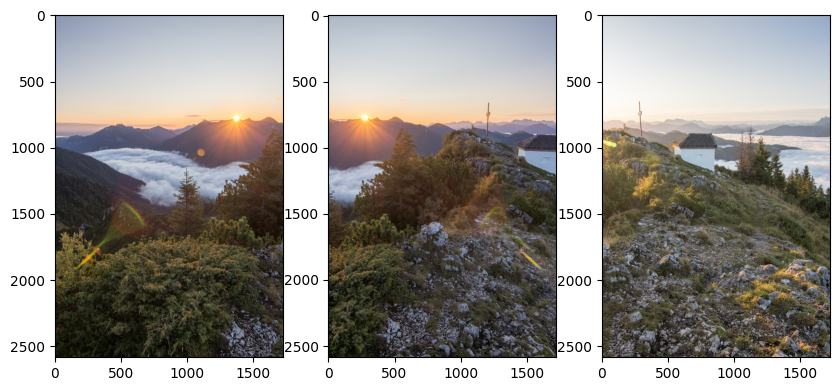

In [2]:
##### TODO: adapt n_images to your number of images, and adapt the paths below to load your images
# single images named 1.jpg, 2.jpg etc.
n_images = 3

# fill list of paths 
image_paths=[]
for i in range(n_images):
    image_paths.append('img/'+str(i+1)+'.jpg')
    
##### END STUDENT CODE
    
    
# fill list of images 
imgs = [] 
for i in range(n_images): 
    img = cv2.imread(image_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # in case of memory error, potentially reduce image size
    width = int(img.shape[1]/2)
    height = int(img.shape[0]/2)
    img = cv2.resize(img, (width, height))
    
    imgs.append(img) 
     
# show the original pictures 
fig, axes = plt.subplots(1, n_images, figsize=(10, 40))
for i in range(n_images): 
    axes[i].imshow(imgs[i])  

## Panorama stitching - the fast way

Let's start by following the fast method to stitch a panorama using OpenCV's `Stitcher` class. Note that depending on your choice of single images, the stitching is not always successful. Also note that due to the underlying random sampling in RANSAC, the result is not deterministic, you might get different results for multiple code runs. 

Your panorama is ready :-)


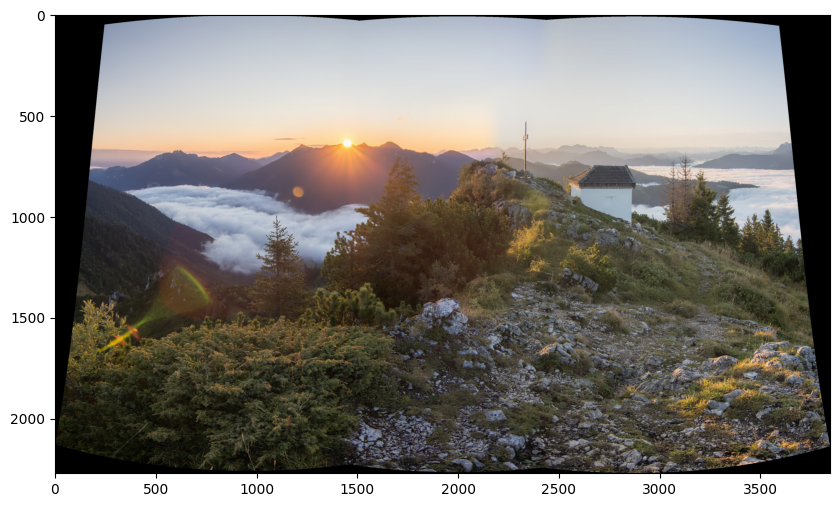

In [3]:
# create stitcher object and stitch images
stitchy=cv2.Stitcher.create() 
(dummy,output)=stitchy.stitch(imgs) 

# check if the stitching procedure was successful   
if dummy != cv2.STITCHER_OK: 
  # .stitch() returns a true value if stitching is  
  # done successfully 
    print("Stitching was't successful!") 
else:  
    print('Your panorama is ready :-)') 
  
    # final output 
    fig, ax = plt.subplots(1,1, figsize=(10, 30))
    ax.imshow(output) 

## Panorama stitching - step by step

Now let's again stitch a panorama without using the `Stitcher` class in order to understand what is happening under the hood. For the sake of simplicity, we only use the first two images for stitching. First we double the size of the second image to make room for the first image to be warped into this new image. The result looks as follows: 

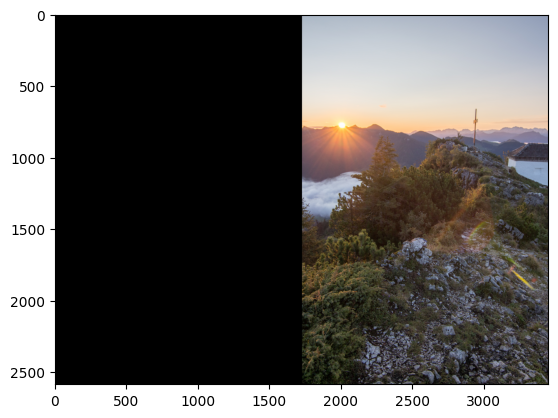

In [4]:
# create a blank image the same size as the second image - note that an image is just a numpy array here
blank_image = np.zeros((imgs[1].shape[0], imgs[1].shape[1], 3), np.uint8)

# horizontally concatenates images of same height  
imgs[1] = cv2.hconcat([blank_image, imgs[1]]) 
plt.imshow(imgs[1])

Task 2: SIFT Descriptors
=

Now we use SIFT to detect feature points and descriptors in both images and we plot the descriptors.

**TODO**: 2a) Use OpenCV's SIFT method to detect keypoints and descriptors of the two images. Plot the resulting keypoints and descriptors in the two images. **(4 points)**

**Hint:** You can use the example code from the lecture slides as reference.

In [5]:
##### TODO: Instanciate SIFT detector
sift = cv2.SIFT_create(contrastThreshold = 0.05, edgeThreshold = 0.05)

##### TODO: find the keypoints and descriptors with SIFT
gray1 = cv2.cvtColor(imgs[0], cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(imgs[1], cv2.COLOR_BGR2GRAY)

keyPoints1, des1 = sift.detectAndCompute(gray1, None)
keyPoints2, des2 = sift.detectAndCompute(gray2, None)

img1 = imgs[0].copy()
img2 = imgs[1].copy()

siftImage1 = cv2.drawKeypoints(img1, keyPoints1, img1, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
siftImage2 = cv2.drawKeypoints(img2, keyPoints2, img2, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


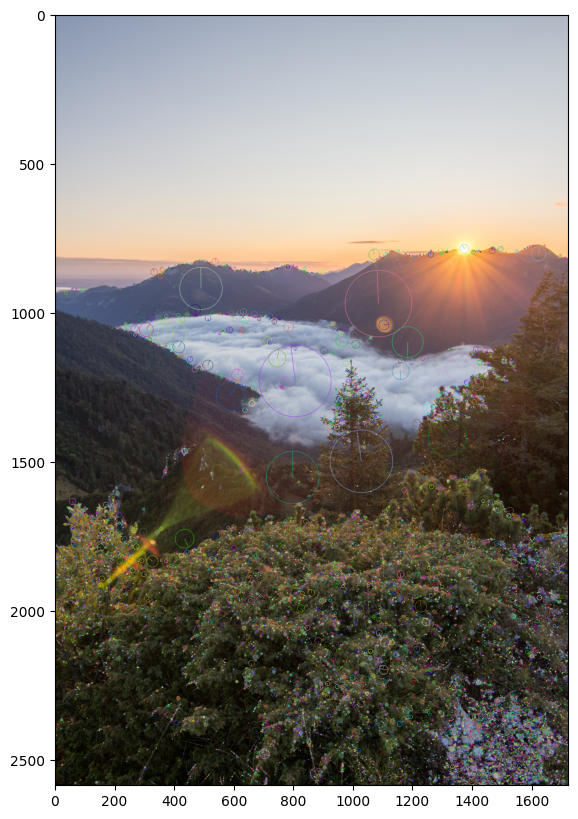

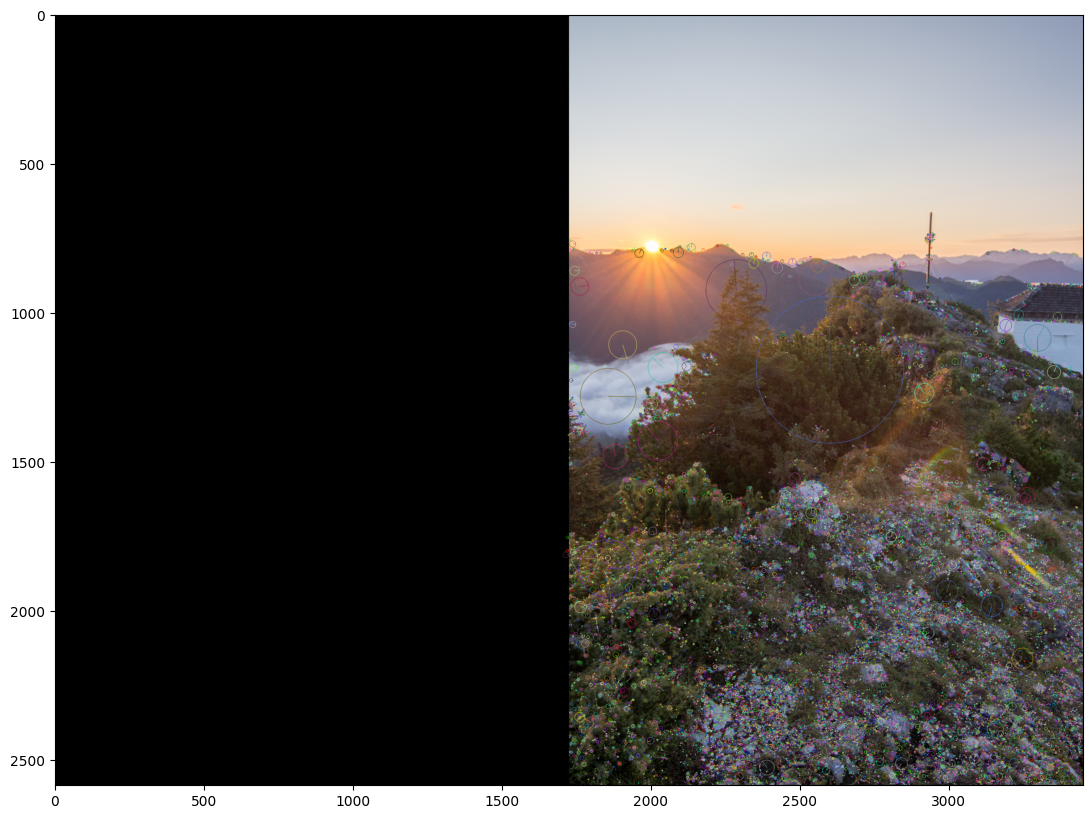

In [6]:
##### TODO: plot result 
plt.figure(figsize=(20,10))
plt.imshow(siftImage1)
plt.show()

plt.figure(figsize=(50,10))
plt.imshow(siftImage2)
plt.show()

**TODO**: 2b) Why do we use SIFT feature points and not Harris Corners for matching? **(2 points)**

**YOUR ANSWER:** While we do panaroma stitching we can use rotated or different scale of images of same place. Harris Corners rotation invariant because of that with rotated pictures it can detect the corners, however the algorithm is not scale invariant because of that it can be see corners as an edge. This results in losing features.

Task 3: Matching Feature Points
=

**TODO**: 3a) Find matches between the two images using FLANN (Fast Library for Approximate Nearest Neighbors).  **(2 points)**

**Hint:** You can find a documentation of FLANN here: https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html 

In [7]:
##### TODO: find matches with FLANN
# FLANN parameters
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
 
flann = cv2.FlannBasedMatcher(index_params,search_params)
 
matches = flann.knnMatch(des1,des2,k=2)

**TODO**: 3b) Store good matches following Lowe's ratio test (see lecture slides). Again, you can use the documentation linked above. **(2 points)**

In [8]:
##### TODO: store all the good matches in a list as per Lowe's ratio test.

# Need to draw only good matches, so create a mask
matchesMask = [[0,0] for i in range(len(matches))]
 
# ratio test as per Lowe's paper
good = []
for i,(m,n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        matchesMask[i]=[1,0]
        good.append(m)
 

**TODO**: 3c) Why do we look at two different distances in Lowe's ratio test? Why not simply use a threshold? **(2 points)**

**YOUR ANSWER:** Nearest Neighbor always gives best match and this might be wrong. If we get correct match then best match should be much better than the second best match. If we get incorrect match then best and second best matches are similar. In other words, we look at two different distances in Lowe's ratio test because we want to ensure that the best match is significantly better than the second-best one.

Task 4: Model Fitting (RANSAC)
=

**TODO**: 4a) Use the matches to calculate a homography between the two images. Print the homography matrix. **(3 points)**

**Hint**: You can find a tutorial on RANSAC here: https://docs.opencv.org/4.x/d1/de0/tutorial_py_feature_homography.html

In [9]:
##### TODO: YOUR CODE GOES HERE

if len(good) > 10:
    src_pts = np.float32([ keyPoints1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ keyPoints2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
else:
    print( "Not enough matches are found - {}/{}".format(len(good), 10) )
    matchesMask = None

print(M)


[[ 2.50903295e+00  2.77029962e-01 -4.25051294e+02]
 [ 3.43745270e-01  1.65149754e+00 -5.06078128e+02]
 [ 4.32612502e-04  2.95091148e-05  1.00000000e+00]]


**TODO:** 4b) Which of the 9 values in the homography matrix was not computed by RANSAC? Where does this value come from, and could you theoretically use another number instead?  **(2 points)**

**YOUR ANSWER:** the only value of M that we could predict, is 1 in the bottom right corner (3,3). This value comes from the homogeneus transformation, yes we could theorically use any other number in the homogenous transformation, because it is invariant under scale.

**TODO**: 4c) Plot the two images and draw matches between features in the two images in red. Apply the homography to the boundary of the first image and plot the new boundary (after applying the homography) in blue into the second image.  **(4 points)**

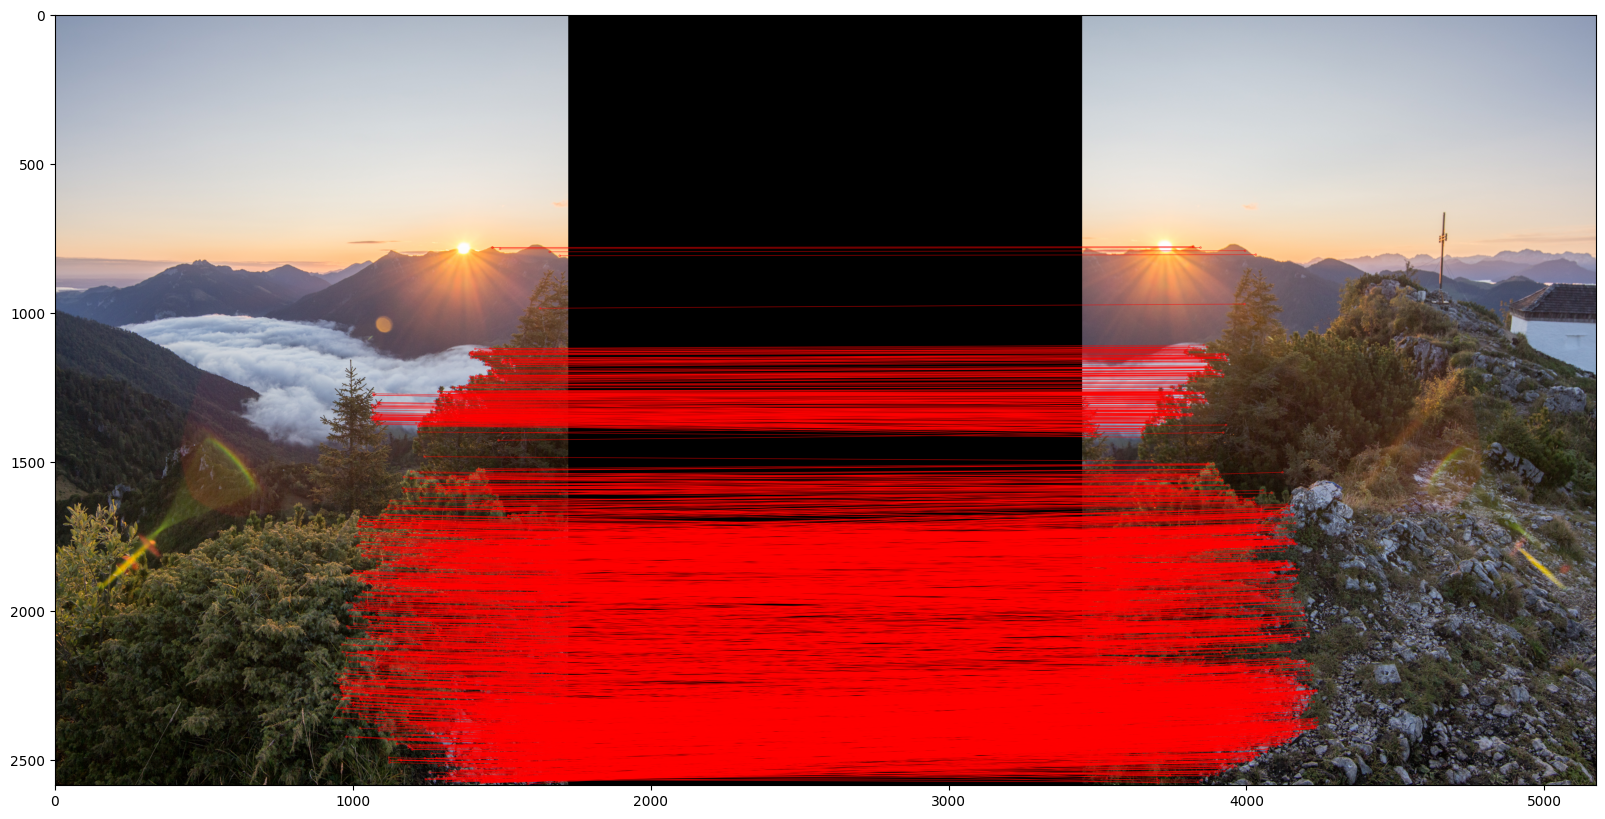

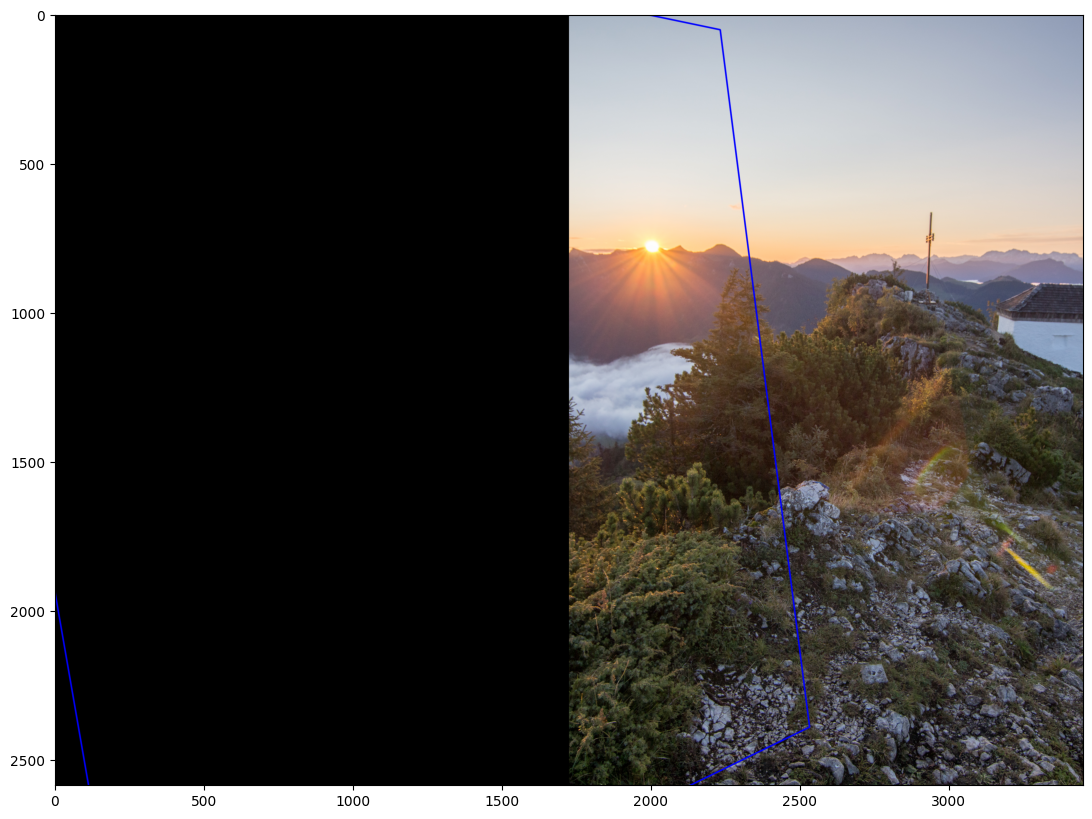

In [10]:
##### TODO: YOUR CODE GOES HERE

# matches between the two images in red.
draw_params = dict(matchColor = (255,0,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(imgs[0],keyPoints1,imgs[1],keyPoints2,good,None,**draw_params)
plt.figure(figsize=(50,10))
plt.imshow(img3)

# apply the omography at the bundary of the second image
h,w = gray1.shape
pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
dst = cv2.perspectiveTransform(pts,M)

img2_new = cv2.polylines(imgs[1].copy(),[np.int32(dst)],True,(0,0,255),3, cv2.LINE_AA)

plt.figure(figsize=(50,10))
plt.imshow(img2_new)

**TODO**: 4d) Finally, warp the first image into the second using the homography. You can use OpenCV's `warpPerspective()` to do this - look up the interface in the online documentation. Afterwards, blend the warped first image and the second image and plot the final panorama. **(2 points)**

**Hint:** To blend the two images, you can simply use the `add()` function as learned in the lesson. However, this will cause the overlapping area to be very light, because both pixel values add up. Alternatively, you can use `addWeighted()` with a blending factor `alpha` of 0.5. See the documentation here: https://docs.opencv.org/3.4/d5/dc4/tutorial_adding_images.html.

Text(0.5, 1.0, 'blended')

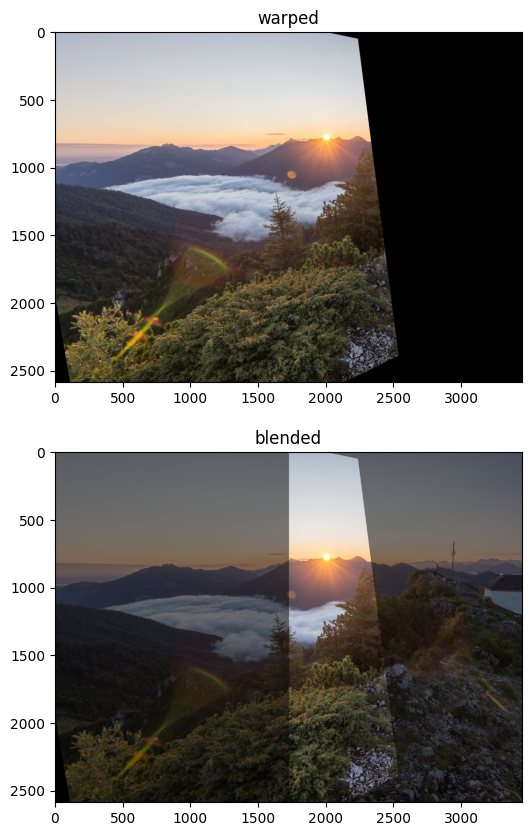

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(50,10))

##### TODO: Warp the first image using the homograph
h, w, channels = imgs[1].shape
warped_img = cv2.warpPerspective(imgs[0], M, (w, h))
ax1.imshow(warped_img)
ax1.set_title("warped")

##### TODO: Blend the warped image with the second image using alpha blending
alpha = 0.5
beta = 1 - alpha
blended_img = cv2.addWeighted(warped_img, alpha, imgs[1], beta, 0.0)

##### TODO: Display the blended image
ax2.imshow(blended_img)
ax2.set_title("blended")


That's it! You have just stitched your first panorama :-)

Task 5: Theory Questions
=

**TODO**: 5a) You have bought a new camera lens with a focal length of 50mm for your SLR camera. You know that the distance between the lens and the camera sensor is 6cm. How far away from the lens should you place an object to be in focus in the image? Explain your result either by writing the calculations down or by text. **(2.5 points)**

**YOUR ANSWER**:
The object can be place at 0.3 m, to be in focus.
The formula has been found as an exercise, we just controlled the result form the slide

&nbsp;

![Screenshot](./img/5aa.jpg)

&nbsp;

![Screenshot](./img/5aaa.jpg)

&nbsp;

![Screenshot](./img/5a.png)

**TODO**: 5b) You are using a camera with intrinsic camera matrix $K=\begin{pmatrix}
2642 & 0 & 1034\\
0 & 2642 & 764\\
0 & 0 & 1
\end{pmatrix}$ (values given in pixels). What are the values of your 5 intrinsic parameters? **(2.5 points)**

**YOUR ANSWER**: Intrinsic camera matrix
$K=\begin{pmatrix} f & s & cx \\ 0 & af & cy\\ 0 & 0 & 1 \end{pmatrix}$ 
&nbsp;

The value can be read by the just looking at the matrix
position (1,1) we have the ***Focal Distance f*** = 2642
position (1,2) we have the ***skew s*** = 0 
position (2,2) we have the product between a and f ==> ***aspect ratio a*** = 1 
position (1,3) and (2,3) we have the ***principal coordinates*** on x and y axis ***cx*** = 1034, ***cy*** = 764

These are the 5 intrinsic value.


**TODO**: 5c) You are taking a picture of an object located 10 meters away at the point $P=\begin{pmatrix}0\\0\\10\end{pmatrix}$ (in camera coordinates) with the camera from 5b). Which are the pixel coordinates of the corresponding image point? What is special about this point? **(2 points)**

**YOUR ANSWER**: 
&nbsp;

![Screenshot](./img/5c.png)

&nbsp;
The point is **principal** point.

**TODO**: 5d) Consider the image point $\begin{pmatrix}1034\\ 764 \end{pmatrix}$ in pixel coordinates. What can you tell about the corresponding real object that was projected onto this image point using the camera from 5b)? What do you know about its 3D camera coordinates? **(2 points)**

**YOUR ANSWER**: We can not say much about this point, since we can not know the distance at which it is form the camera,its camera coordinates can be expressed like this $P=\begin{pmatrix}0\\0\\z\end{pmatrix}$ with z any positive real number
